# DATA ENGINEERING - GANS PROJECT

Gans is a startup developing an e-scooter-sharing system. It aspires to operate in the most populous cities all around the world. In each city, the company will have hundreds of e-scooters parked in the streets and allow users to rent them by the minute.

The company wants to anticipate as much as possible scooter movements. Predictive modelling is certainly on the roadmap, but the first step is to collect more data, transform it and store it appropriately. This is where you come in: your task will be to collect data from external sources that can potentially help Gans predict e-scooter movement. Since data is needed every day, in real-time and accessible by everyone in the company, the challenge is going to be to assemble and automate a data pipeline in the cloud.

## 1. Importing libraries

In [8]:
# Use the system command to install the 'sqlalchemy' package. SQLAlchemy provides a set of high-level API to connect to relational databases.
#!pip install sqlalchemy 

# Use the system command to install the 'pymysql' package. PyMySQL is a Python MySQL client library that allows for connecting to MySQL databases.
#!pip install pymysql

# Importing the BeautifulSoup class from the bs4 library for parsing and navigating through HTML/XML.
from bs4 import BeautifulSoup

# Importing the requests library to facilitate making HTTP requests.
import requests

# Importing the pandas library for data analysis and manipulation. Using the "pd" alias for shorthand.
import pandas as pd

# Importing the re module to support operations using regular expressions.
import re

# Importing the json module for encoding and decoding JSON data.
import json

# Importing the datetime class from the datetime module for date and time operations.
from datetime import datetime

# Importing the pytz library to work with the Olson tz database for timezone operations.
import pytz

# Importing the timezone class directly from pytz to create timezone objects.
from pytz import timezone

# Importing datetime (redundantly), along with date and timedelta classes from the datetime module.
# These are for various date and time operations. The redundant import of datetime can be removed.
from datetime import datetime, date, timedelta

# Import the entire 'sqlalchemy' module. This module provides tools to work with relational databases.
import sqlalchemy

# From the 'sqlalchemy' module, import the 'update' function. This function is used to build update statements in SQLAlchemy.
from sqlalchemy import update

In [9]:
with open("C:\\Users\\agata\\OneDrive\\Desktop\\Data Science Bootcamp\\Data Engeneering\\API_key.txt", 'r') as file:
    my_API_key = file.read().strip()

In [21]:
with open("C:\\Users\\agata\\OneDrive\\Desktop\\Data Science Bootcamp\\Data Engeneering\\API_key2.txt", 'r') as file:
    my_API_key2 = file.read().strip()

## 2. Web Scraping: Collect demographical data

There are many places where you could retrieve information about cities from. You could download a csv document from a place like Eurostat. But this data is static, and would be soon outdated by the quick changes modern cities experiment.

The company has suggested to simply grab data from wikipedia. The global community takes care to frequently update and curate the data, so you just need to care about grabbing the right numbers.

In [11]:
def recreate_wiki(cities):
    
    # Initialize an empty list to store dictionaries containing city data.
    list_for_df = []
    
    # Loop through each city provided in the list.
    for city in cities:

        # Construct the Wikipedia URL for the current city.
        url = f'https://en.wikipedia.org/wiki/{city}'

        # Send an HTTP GET request to fetch the Wikipedia page for the city.
        r = requests.get(url)

        # Parse the returned HTML content using BeautifulSoup.
        soup = BeautifulSoup(r.content, 'html.parser')

        # Initialize a dictionary to store extracted city data.
        response_dict = {}

        # Extract and store data from the Wikipedia page into the dictionary.
        response_dict['city'] = soup.select(".firstHeading")[0].get_text()
        response_dict['country'] = soup.select(".infobox-data")[0].get_text()
        response_dict['latitude'] = soup.select(".latitude")[0].get_text()
        response_dict['longitude'] = soup.select(".longitude")[0].get_text()

        # Check if there's a "Population" header in the infobox and extract the population value if present.
        if soup.select_one('th.infobox-header:-soup-contains("Population")'):
            response_dict['population'] = soup.select_one('th.infobox-header:-soup-contains("Population")').parent.find_next_sibling().find(string=re.compile(r'\d+'))
        
        # Append the dictionary containing the city's data to the list.
        list_for_df.append(response_dict)
    
    # Convert the list of dictionaries into a pandas DataFrame.
    cities_df = pd.DataFrame(list_for_df)
      
    # Clean and transform the extracted data.
    cities_df['population'] = cities_df['population'].str.rstrip('(')

    # Convert latitude from degree-minute-second format to decimal format.
    cities_df['latitude'] = cities_df['latitude'].str.rstrip('N').str.split('″').str[0].str.replace('°', '.', regex=False).str.replace('′', '', regex=False)
    cities_df["latitude"] = pd.to_numeric(cities_df["latitude"])
    cities_df["latitude"] = cities_df.latitude.round(2)

    # Convert longitude from degree-minute-second format to decimal format.
    cities_df['longitude'] = cities_df['longitude'].str.rstrip('E').str.split('″').str[0].str.replace('°', '.', regex=False).str.replace('′', '', regex=False)
    cities_df["longitude"] = pd.to_numeric(cities_df["longitude"])
    cities_df["longitude"] = cities_df.longitude.round(2)

    # Remove commas from the population column and convert to integer type.
    cities_df['population'] = cities_df['population'].apply(lambda x: x.replace(',', '')).astype('int')
      
    # Initialize the city_id column with empty strings.
    cities_df['city_id'] = ''
    
    # Map specific cities to their corresponding IDs. [Note: This approach may not work correctly since the city order might change. Consider using a dictionary mapping instead.]
    cities_df['city_id'] = ['1', '2', '3', '4', '5']

    return cities_df

In [12]:
# Define a list of city names.
list_of_cities = ['Berlin', 'London', 'Barcelona', 'Cagliari', 'Amsterdam']

# Use the 'recreate_wiki' function to scrape data about the cities from Wikipedia and return a DataFrame.
recreate_wiki(list_of_cities).head()
# Display the first five rows of the resulting DataFrame using the 'head' method.


,city,country,latitude,longitude,population,city_id
0,Berlin,Germany,52.31,13.24,3850809,1
1,London,United Kingdom,51.30,0.74,8799800,2
2,Barcelona,Spain,41.23,2.10,1620343,3
3,Cagliari,Italy,39.13,9.06,154460,4
4,Amsterdam,Netherlands,52.22,4.53,921402,5


In [13]:
# Call the 'recreate_wiki' function with the 'list_of_cities' to scrape data about the cities from Wikipedia. 
# The resulting data is converted into a pandas DataFrame and stored in the 'cities_info' variable.
cities_info = pd.DataFrame(recreate_wiki(list_of_cities))

In [14]:
# Extract the 'city_id', 'city', and 'country' columns from the 'cities_info' DataFrame 
# and store the subset in a new DataFrame called 'cities'.
cities = cities_info[['city_id', 'city', 'country']]

# Display the 'cities' DataFrame.
cities

,city_id,city,country
0,1,Berlin,Germany
1,2,London,United Kingdom
2,3,Barcelona,Spain
3,4,Cagliari,Italy
4,5,Amsterdam,Netherlands


## 3. Collecting data with APIs

An API is a set of rules and protocols that specifies how two software programs should interact with each other. It allows one software application to access the features or data of another application, enabling the exchange of information between the two systems. Data Scientists have to learn how to write the necessary code to use an API:

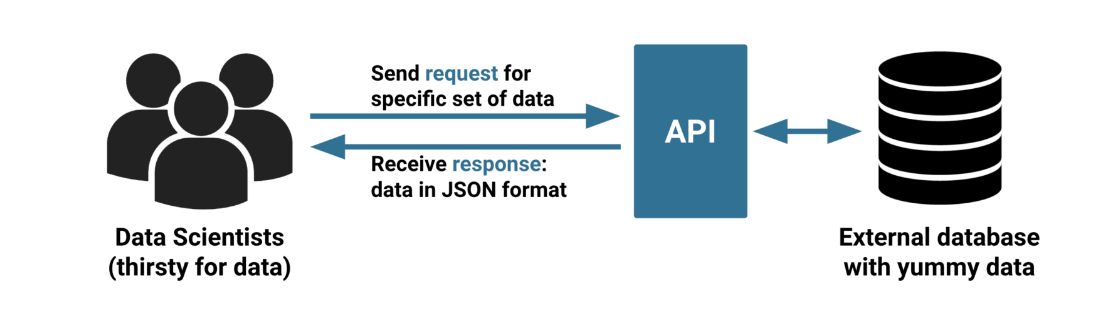

### 3.1 APIs 1: Collect weather data

Weather is a huge factor when it comes to scooter usage. On very cold days and, especially, on rainy days, hardly anyone wants to use a scooter.

This function below fetches and processes the weather forecast data for a given list of cities using the OpenWeatherMap API. The comments provide a detailed explanation of each step.

In [15]:
def get_weather_loop(cities):
    
    # Define the API key for OpenWeatherMap.
    API_key = my_API_key
    
    # Set the timezone to 'Europe/Berlin' and get the current date and time in that timezone.
    tz = pytz.timezone('Europe/Berlin')
    now = datetime.now().astimezone(tz) 
  
    # Initialize a dictionary to structure the weather data before converting to a DataFrame.
    weather_dict = {'city_id': [],
                    'country': [],
                    'forecast_time': [],
                    'weather': [],
                    'temperature': [],
                    'temperature_feels_like': [],
                    'clouds': [],
                    'rain': [],
                    'snow': [],
                    'wind_speed': [],
                    'humidity': [],
                    'pressure': [],
                    'information_retrieved_at': []}

    # Loop through each city to fetch the weather forecast data.
    for city in cities:
        
        # Construct the API URL for fetching weather forecast data for the given city.
        url =(f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_key}&units=metric")
        # Send an HTTP GET request to fetch the weather data for the city.
        response = requests.get(url)
        # Convert the response to JSON format.
        cities_weather = response.json()
        
        # Loop through each forecast data in the 'list' key of the response.
        for i in cities_weather['list']:
            # Assign city IDs based on city names.
            if city == 'Berlin':
                weather_dict['city_id'].append(1)
            elif city == 'London':
                weather_dict['city_id'].append(2)
            elif city == 'Barcelona':
                weather_dict['city_id'].append(3)
            elif city == 'Cagliari':
                weather_dict['city_id'].append(4)
            elif city == 'Amsterdam':
                weather_dict['city_id'].append(5)
            elif city == 'Gdansk':
                weather_dict['city_id'].append(6)
            else:
                weather_dict['city_id'].append(0)
                
            # Extract data from the forecast and append to the dictionary.        
            weather_dict['country'].append(cities_weather['city']['country'])
            weather_dict['forecast_time'].append(i['dt_txt'])
            weather_dict['weather'].append(i['weather'][0]['main'])
            weather_dict['temperature'].append(i['main']['temp'])
            weather_dict['temperature_feels_like'].append(i['main']['feels_like'])
            weather_dict['clouds'].append(i['clouds']['all'])
            weather_dict['wind_speed'].append(i['wind']['speed'])
            weather_dict['humidity'].append(i['main']['humidity'])
            weather_dict['pressure'].append(i['main']['pressure'])
            
            # If rain data is available, append it. Otherwise, append '0'.
            try:
              weather_dict['rain'].append(i['rain']['3h'])
            except:
              weather_dict['rain'].append('0')
            # If snow data is available, append it. Otherwise, append '0'.
            try:
              weather_dict['snow'].append(i['snow']['3h'])
            except:
              weather_dict['snow'].append('0')
            
            # Append the time when the information was retrieved.
            weather_dict['information_retrieved_at'].append(now.strftime("%d/%m/%Y %H:%M:%S"))

    return pd.DataFrame(weather_dict)

In [16]:
# Call the 'get_weather_loop' function with a list of cities to retrieve their weather forecast data.
# The resulting data is converted into a pandas DataFrame and stored in the 'cities_weather' variable.
cities_weather = pd.DataFrame(get_weather_loop(['Berlin', 'London', 'Barcelona', 'Cagliari', 'Amsterdam']))

In [17]:
# Display the first five rows of the 'cities_weather' DataFrame to get a quick overview of the data.
cities_weather.head()

,city_id,country,forecast_time,weather,temperature,temperature_feels_like,clouds,rain,snow,wind_speed,humidity,pressure,information_retrieved_at
0,1,DE,2023-08-25 00:00:00,Rain,21.73,21.73,32,0.43,0,2.68,68,1010,24/08/2023 23:37:07
1,1,DE,2023-08-25 03:00:00,Clouds,20.81,20.75,41,0,0,2.65,69,1009,24/08/2023 23:37:07
2,1,DE,2023-08-25 06:00:00,Clouds,21.67,21.67,56,0,0,2.57,68,1009,24/08/2023 23:37:07
3,1,DE,2023-08-25 09:00:00,Clouds,26.40,26.40,97,0,0,3.15,53,1009,24/08/2023 23:37:07
4,1,DE,2023-08-25 12:00:00,Clouds,29.21,29.23,89,0,0,3.37,44,1008,24/08/2023 23:37:07


### 3.2 APIs 2: Collect flights data

Tourists are a big share of the Gans’ user base. And a lot of urban tourists travel by plane, with just a backpack. This is why we want to collect data about flights landing to our cities of interest.

We could scrape a website that contains this information, but most likely it would be an arduous task to maintain the code and clean all the information. A structured way to collect data from the internet is by using APIs.

* Rapid API is a marketplace for APIs. A lot of APIs have “Freemium” pricing plans: they allow you to access certain information a certain amount of times, and beyond those limits, they charge you per request. 

Fortunately, accessing flight landings data is free.

#### 3.2.1 Airports

In [23]:
def icao_airport_codes(latitudes, longitudes):
    """
    Fetches airport data based on given latitudes and longitudes.
    
    Parameters:
    - latitudes (list): List of latitudes.
    - longitudes (list): List of longitudes.
    
    Returns:
    - DataFrame: A consolidated dataframe containing airport details.
    """

    # Assert that the length of both latitudes and longitudes are equal
    assert len(latitudes) == len(longitudes)
  
    # Initialize an empty list to store airport dataframes
    list_for_airports = []

    # Loop through all latitudes and longitudes
    for i in range(len(latitudes)):
        
        # URL to fetch airport data based on location (latitude and longitude)
        url = f"https://aerodatabox.p.rapidapi.com/airports/search/location/{latitudes[i]}/{longitudes[i]}/km/100/16"

        # Additional parameters for the API request
        querystring = {"withFlightInfoOnly":"true"}

        # Headers required for the API request
        headers = {
            "X-RapidAPI-Key": my_API_key2,
            "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
        }

        # Making the GET request to fetch airport data
        response = requests.request("GET", url, headers=headers, params=querystring)
        
        # Parsing the response to JSON
        airports_resp = response.json()
        
        # Convert the relevant parts of the JSON response into a DataFrame
        airports_df = pd.json_normalize(airports_resp['items'])[['icao','name','countryCode','location.lat','location.lon']]
        
        # Rename columns for clarity
        airports_df = airports_df.rename(columns={'icao':'airport_icao','name':'airport_name','countryCode':'country_code','location.lat':'latitude','location.lon':'longitude'})
        
        # Round the latitude and longitude to 2 decimal places
        airports_df["latitude"] = airports_df.latitude.round(2)
        airports_df["longitude"] = airports_df.longitude.round(2)
        
        # Append the dataframe to the list
        list_for_airports.append(airports_df)

    # Concatenate all dataframes in the list to form a consolidated dataframe
    return pd.concat(list_for_airports, ignore_index=True)

# Example usage
icao_airport_codes([52.31, 51.30, 41.23, 38.77, 52.22],[13.24, 0.74, 2.11, 9.13, 4.53])

,airport_icao,airport_name,country_code,latitude,longitude
0,EDDB,Berlin Brandenburg,DE,52.35,13.49
1,EGMC,Southend,GB,51.57,0.70
2,EGLC,London City,GB,51.51,0.06
3,EGKR,Redhill Aerodrome,GB,51.21,-0.14
4,EGKK,London Gatwick,GB,51.15,-0.19
5,EGSS,London Stansted,GB,51.88,0.23
6,EGLL,London Heathrow,GB,51.47,-0.46
7,EGGW,London Luton,GB,51.87,-0.37
8,LEBL,Barcelona,ES,41.30,2.08
9,LERS,Reus Air Base,ES,41.15,1.17


In [24]:
# Create a DataFrame 'cities_airports' by fetching airport data for given latitudes and longitudes using the 'icao_airport_codes' function.
cities_airports = pd.DataFrame(icao_airport_codes([52.31, 51.30, 41.23, 38.43, 52.22], [13.24, 0.74, 2.11, 9.09, 4.53]))

In [25]:
# Display the summary of the 'cities_airports' DataFrame, including the count of non-NA values, data type, and memory usage.
cities_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   airport_icao  14 non-null     object 
 1   airport_name  14 non-null     object 
 2   country_code  14 non-null     object 
 3   latitude      14 non-null     float64
 4   longitude     14 non-null     float64
dtypes: float64(2), object(3)
memory usage: 688.0+ bytes


#### 3.2.2 Flights arrivals

In [26]:
def tomorrows_flight_arrivals(icao_list):
    # Get today's date in the 'Europe/Berlin' timezone.
    today = datetime.now().astimezone(timezone('Europe/Berlin')).date()
    # Calculate tomorrow's date.
    tomorrow = (today + timedelta(days=1))

    # Initialize an empty list to store the flight arrivals data for different times.
    list_for_arrivals = []

    # Iterate over each ICAO code provided in the list.
    for icao in icao_list:
        # Define two time intervals to fetch flight data.
        times = [["00:00","11:59"],["12:00","23:59"]]

        # Iterate over each time interval.
        for time in times:
            # Construct the API URL using hardcoded values (this needs to be fixed to use the above variables).
            url = "https://aerodatabox.p.rapidapi.com/flights/airports/icao/EDDB/2023-03-07T00:00/2023-03-07T11:59"

            # Define API parameters.
            querystring = {"withLeg":"true","direction":"Arrival","withCancelled":"false","withCodeshared":"true"}

            # Define API headers, including the API key.
            headers = {
                "X-RapidAPI-Key": my_API_key2,
	            "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
            }
    
            # Make the API request.
            response = requests.request("GET", url, headers=headers, params=querystring)
            flights_json = response.json()
    
            # Convert the JSON response into a DataFrame.
            cities_arrivals = pd.json_normalize(flights_json['arrivals'])[['number', 'arrival.scheduledTimeLocal', 'departure.airport.name','departure.airport.icao', 'airline.name']]
            
            # Rename columns for clarity.
            cities_arrivals = cities_arrivals.rename(columns={
                'number':'flight_number',
                'airline.name' : 'airline',
                'arrival.scheduledTimeLocal':'arrival_time',
                'departure.airport.name': 'departure_city',
                'departure.airport.icao': 'departure_airport_icao'
            })
            
            # Add additional columns to the DataFrame.
            cities_arrivals['arrival_airport_icao'] = icao
            cities_arrivals['data_retrived_on'] = datetime.now().date()
            cities_arrivals = cities_arrivals[['arrival_airport_icao', 'flight_number', 'airline', 'arrival_time', 'departure_city', 'departure_airport_icao', 'data_retrived_on']]
      
            # Extract the datetime without the timezone.
            cities_arrivals['arrival_time'] = cities_arrivals['arrival_time'].str.split('+').str[0]
            
            # Convert the 'arrival_time' and 'data_retrived_on' columns to datetime format.
            cities_arrivals['arrival_time'] = pd.to_datetime(cities_arrivals['arrival_time'])
            cities_arrivals['data_retrived_on'] = pd.to_datetime(cities_arrivals['data_retrived_on'])
   
            # Append the data for this time interval to the list.
            list_for_arrivals.append(cities_arrivals)

    # Concatenate the data for all time intervals and ICAO codes into a single DataFrame.
    return pd.concat(list_for_arrivals, ignore_index=True)


In [27]:
# Define a list containing the ICAO code for the Berlin Brandenburg Airport.
icao_list = ['EDDB']

# Fetch tomorrow's flight arrivals data for the airports in the icao_list using the 'tomorrows_flight_arrivals' function.
result_arrivals = tomorrows_flight_arrivals(icao_list)

# Print the first 20 rows of the retrieved flight arrivals data.
print(result_arrivals.head(20))

   arrival_airport_icao flight_number                airline  \
0                  EDDB       AZD 212                    AZD   
1                  EDDB         QR 79          Qatar Airways   
2                  EDDB       4U 2002            Germanwings   
3                  EDDB       4U 52FP            Germanwings   
4                  EDDB         DCVFA  Unknown/Private owner   
5                  EDDB         EW 12              Eurowings   
6                  EDDB       EW 2002              Eurowings   
7                  EDDB       EW 9048              Eurowings   
8                  EDDB        LH 170              Lufthansa   
9                  EDDB       DJ 6228           Star Air A/S   
10                 EDDB        UA 962                 United   
11                 EDDB       AY 1431                Finnair   
12                 EDDB        DX 121             Danish Air   
13                 EDDB       EW 4600              Eurowings   
14                 EDDB       FR 3391   

In [28]:
# Retrieve tomorrow's flight arrivals data for the airports in the icao_list using the 'tomorrows_flight_arrivals' function, and then convert the result into a DataFrame named 'cities_arrivals'.
cities_arrivals = pd.DataFrame(tomorrows_flight_arrivals(icao_list))

In [29]:
# Display the summary of the 'cities_arrivals' DataFrame. This includes information like the count of non-NA values, data type of each column, and memory usage, providing a quick overview of the data's structure and content.
cities_arrivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   arrival_airport_icao    114 non-null    object        
 1   flight_number           114 non-null    object        
 2   airline                 114 non-null    object        
 3   arrival_time            114 non-null    datetime64[ns]
 4   departure_city          114 non-null    object        
 5   departure_airport_icao  106 non-null    object        
 6   data_retrived_on        114 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(5)
memory usage: 6.4+ KB


## 4. MySQL: Set up a local database

Set up a local database for gans project:

-All the tables in the database

-All the columns for each table

-The relationships for those tables

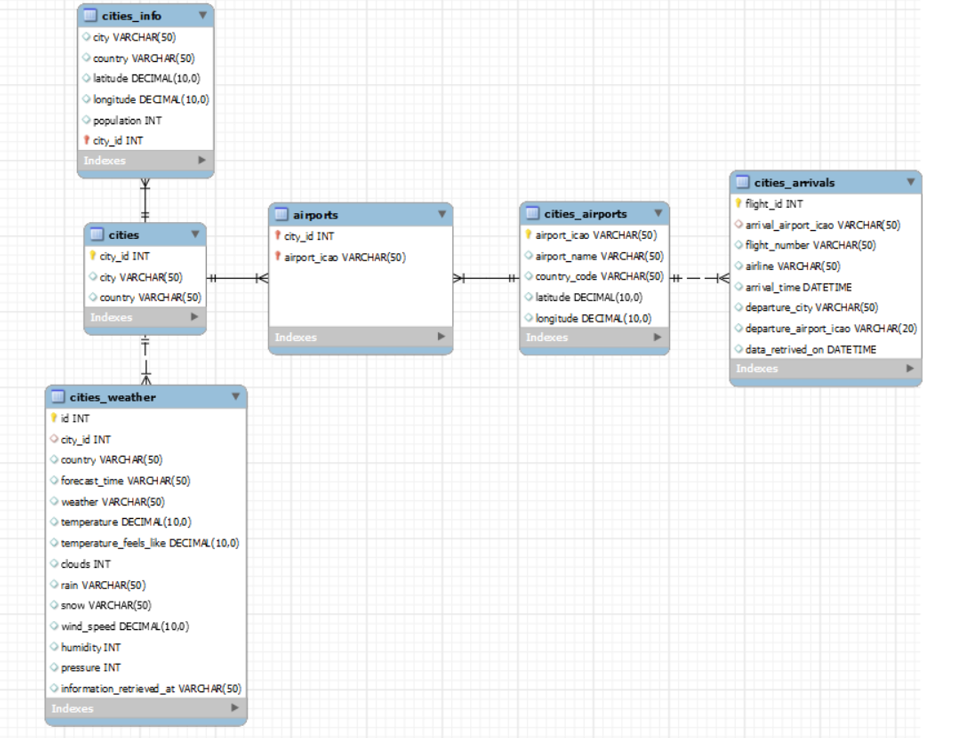

## 5. Connect Python with MySQL, and MySQL with AWS

Exporting data from cities, cities_info, cities_weather, cities_airports and cities_arrivals Python dictionaries or Pandas dataframes to our and empty tables on MySQL.

Tables cities, cities_info, cities_airports are static tables that don't have to be regulary updated, however tables cities_weather and cities_arrivals are dynamic tables as they need to provide up to date information and will be updated regulary.

### 5.1 Setting up AWS RDS instance

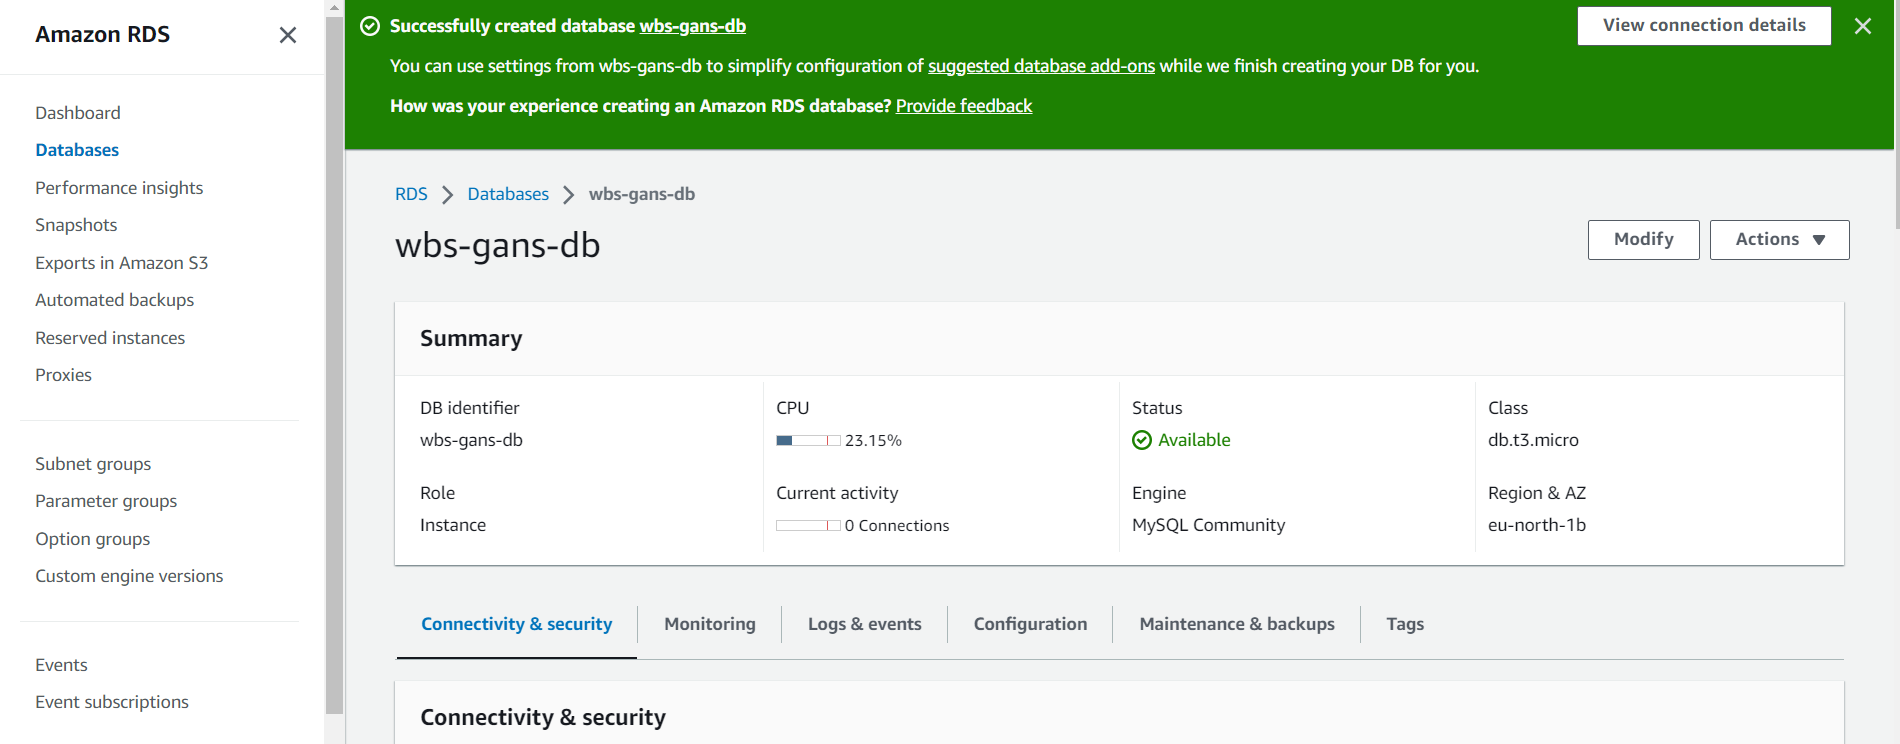

### 5.2  SQLalchemy - pushing data collected in Python to MySQL database

In [31]:
with open("C:\\Users\\agata\\OneDrive\\Desktop\\Data Science Bootcamp\\Data Engeneering\\host_endpoint.txt", 'r') as file:
   endpoint = file.read().strip()

In [32]:
with open("C:\\Users\\agata\\OneDrive\\Desktop\\Data Science Bootcamp\\Data Engeneering\\user.txt", 'r') as file:
   user_name = file.read().strip()

In [33]:
with open("C:\\Users\\agata\\OneDrive\\Desktop\\Data Science Bootcamp\\Data Engeneering\\password.txt", 'r') as file:
   very_secret_password = file.read().strip()

In [34]:
# Define the schema name, which corresponds to the name of the database you want to use.
schema="gans"

# Define the host address. This is the address of the server where the database is hosted, in this case, an AWS RDS instance.
host= endpoint

# Define the username required for authenticating to the database.
user= user_name

# Define the password associated with the given username for authentication. Remember to keep passwords secure and do not expose them in scripts or notebooks.
password= very_secret_password

# Define the port number to use for connecting to the database. Typically, MySQL uses port 3306.
port=3306

# Construct the connection string, which is used by SQLAlchemy to connect to the MySQL database using the PyMySQL driver.
# This string contains the user, password, host, port, and schema details.
con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

In [35]:
# Use the 'to_sql' method of the DataFrame to write the 'cities' DataFrame to a SQL database table.

# 'cities' is the name of the table where the data will be written.
# If a table with the name 'cities' already exists, the data will be appended due to 'if_exists='append''.
# If the table does not exist, a new table will be created.
# 'con' is the connection string to the database.
# 'index=False' ensures that the DataFrame's index will not be written to the database table.
cities.to_sql('cities',            # Name of the table to write data into.
              if_exists='append',  # If the table already exists, append the data. If not, create a new table.
              con=con,             # Use the previously defined connection string.
              index=False)         # Do not write the DataFrame's index to the table.

5

In [36]:
cities_info.to_sql('cities_info',  # 'iss_logs'-> table name;
              if_exists='append',  # if_exists -> will create new table if doesn't exist, otherwise, 'append' - will append data to existing table;
              con=con,             # con-> connection string;
              index=False) 

5

In [37]:
cities_weather.to_sql('cities_weather',         # 'iss_logs'-> table name;
                      if_exists='append',       # if_exists -> will create new table if doesn't exist, otherwise, 'append' - will append data to existing table;
                      con=con,                  # con-> connection string;
                      index=False) 

200

In [38]:
cities_airports.to_sql('cities_airports',         # 'iss_logs'-> table name;
                      if_exists='append',         # if_exists -> will create new table if doesn't exist, otherwise, 'append' - will append data to existing table;
                      con=con,                    # con-> connection string;
                      index=False) 

14

In [39]:
cities_arrivals.to_sql('cities_arrivals',         # 'iss_logs'-> table name;
                      if_exists='append',         # if_exists -> will create new table if doesn't exist, otherwise, 'append' - will append data to existing table;
                      con=con,                    # con-> connection string;
                      index=False) 

114

### 5.3 AWS Lambda: Move script to the cloud

Scripts are already capable of collecting data from the internet and insert it into a cloud database. But they are still being executed from a local computer! 

We're going to use serverless computing. It is a service where you paste your script, set the programming language you are using, and execute it. No need to worry about hardware or operating systems! In AWS, this service is called AWS Lambda.

Every piece of code that runs on Lambda has to be a function, and this is why it is common to speak about “Lambda functions”. AWS Lambda functions (which can be written in many programming languages, including Python) are not to be mistaken with Python’s lambda function (small anonymous functions that have nothing to do with the cloud).

When learning about Lambda, you will often hear about “triggers”. This is because most use cases for serverless computing typically involve code that runs in response to an “event”. Imagine an application where users can upload an image of an object and get back links to buy that object online. The code that recognizes the object and queries e-commerce stores could very well be a Lambda function that gets “triggered” by the image upload. I this case we'll make the code run o timer.

In our lambda function we're focusing on our teo dynamic tables: cities_weather and cities_arrivals, that need to be updated regulary to provide up to date data for Gans.

'''

from bs4 import BeautifulSoup

import requests

import pandas as pd

import sqlalchemy

from sqlalchemy import update

import re

import json

from datetime import datetime

import pytz

from pytz import timezone

from datetime import datetime, date, timedelta

def get_weather_loop(cities):
    
    API_key = "insert your key"
    
    tz = pytz.timezone('Europe/Berlin')
    now = datetime.now().astimezone(tz) 
  
    weather_dict = {'city_id': [],
                    'country': [],
                    'forecast_time': [],
                    'weather': [],
                    'temperature': [],
                    'temperature_feels_like': [],
                    'clouds': [],
                    'rain': [],
                    'snow': [],
                    'wind_speed': [],
                    'humidity': [],
                    'pressure': [],
                    'information_retrieved_at': []}

    for city in cities:
        url =(f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_key}&units=metric")
        response = requests.get(url)
        cities_weather = response.json()

        for i in cities_weather['list']:
            if city == 'Berlin':
                weather_dict['city_id'].append(1)
            elif city == 'London':
                weather_dict['city_id'].append(2)
            elif city == 'Barcelona':
                weather_dict['city_id'].append(3)
            elif city == 'Cagliari':
                weather_dict['city_id'].append(4)
            elif city == 'Amsterdam':
                weather_dict['city_id'].append(5)
            elif city == 'Gdansk':
                weather_dict['city_id'].append(6)
            else:
                weather_dict['city_id'].append(0)
                
            weather_dict['country'].append(cities_weather['city']['country'])
            weather_dict['forecast_time'].append(i['dt_txt'])
            weather_dict['weather'].append(i['weather'][0]['main'])
            weather_dict['temperature'].append(i['main']['temp'])
            weather_dict['temperature_feels_like'].append(i['main']['feels_like'])
            weather_dict['clouds'].append(i['clouds']['all'])
            weather_dict['wind_speed'].append(i['wind']['speed'])
            weather_dict['humidity'].append(i['main']['humidity'])
            weather_dict['pressure'].append(i['main']['pressure'])                                                                  
            try:
              weather_dict['rain'].append(i['rain']['3h'])
            except:
              weather_dict['rain'].append('0')
            try:
              weather_dict['snow'].append(i['snow']['3h'])
            except:
              weather_dict['snow'].append('0')

            weather_dict['information_retrieved_at'].append(now.strftime("%d/%m/%Y %H:%M:%S"))

    return pd.DataFrame(weather_dict)
    
def tomorrows_flight_arrivals(icao_list):

    today = datetime.now().astimezone(timezone('Europe/Berlin')).date()
    tomorrow = (today + timedelta(days=1))

    list_for_arrivals = []
    
    for icao in icao_list:
        times = [["00:00","11:59"],["12:00","23:59"]]
        
        for time in times:
            url = "https://aerodatabox.p.rapidapi.com/flights/airports/icao/EDDB/2023-03-07T00:00/2023-03-07T11:59"

            querystring = {"withLeg":"true","direction":"Arrival","withCancelled":"false","withCodeshared":"true"}

            headers = {
                "X-RapidAPI-Key": ""insert your key"",
                "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
            }
        
            response = requests.request("GET", url, headers=headers, params=querystring)
            flights_json = response.json()
    
            cities_arrivals = pd.json_normalize(flights_json['arrivals'])[['number', 'arrival.scheduledTimeLocal', 'departure.airport.name','departure.airport.icao', 'airline.name']]       
            cities_arrivals = cities_arrivals.rename(columns={'number':'flight_number', 'airline.name' : 'airline','arrival.scheduledTimeLocal':'arrival_time', 'departure.airport.name': 'departure_city','departure.airport.icao': 'departure_airport_icao'})
            cities_arrivals['arrival_airport_icao'] = icao
            cities_arrivals['data_retrived_on']= datetime.now().date()
            cities_arrivals = cities_arrivals[['arrival_airport_icao', 'flight_number', 'airline', 'arrival_time', 'departure_city', 'departure_airport_icao', 'data_retrived_on']]
      
            cities_arrivals['arrival_time']=cities_arrivals['arrival_time'].str.split('+').str[0]
      
            cities_arrivals['arrival_time'] = pd.to_datetime(cities_arrivals['arrival_time'])
            cities_arrivals['data_retrived_on'] = pd.to_datetime(cities_arrivals['data_retrived_on']) 
        
            list_for_arrivals.append(cities_arrivals)
        
    return pd.concat(list_for_arrivals, ignore_index=True)

def lambda_handler(event, context):
    schema="gans"   
    host="insert your endpoint"       
    user="insert your user name"
    password="insert your password" 
    port=xxxx
    con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'
    
    cities_weather=pd.DataFrame(get_weather_loop(['Berlin', 'London', 'Barcelona', 'Cagliari', 'Amsterdam']))
    icao_list = ['EDDB']
    cities_arrivals= pd.DataFrame(tomorrows_flight_arrivals(icao_list))
    
    
    cities_weather.to_sql('cities_weather', if_exists='append', con = con,index=False) 
    cities_arrivals.to_sql('cities_arrivals', if_exists = 'append', con = con, index=False)
    
    return {
        'statusCode': 200,
        'body': json.dumps('Hello from Lambda!')
    }
'''

Before Lambda function can work properly you need add all librris we want to use as different layers. 

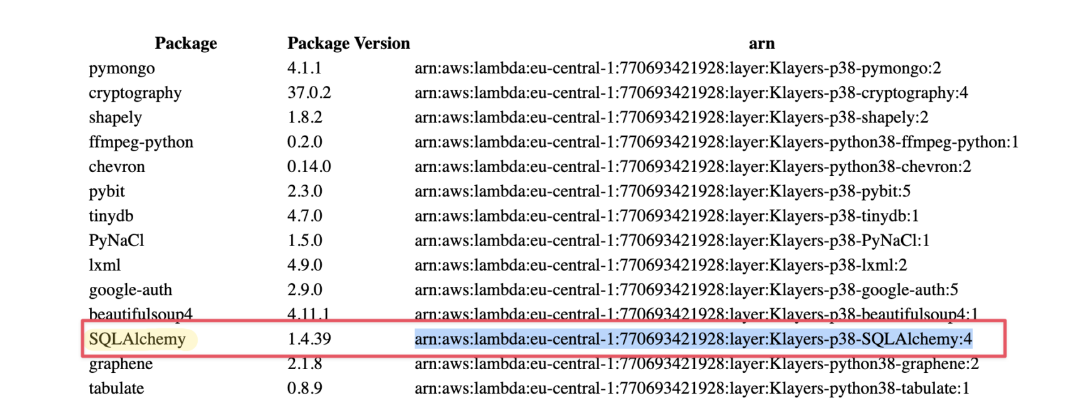

Now when our Lambda function is up and running time to automate it.

### 5.4 Automate the data pipeline - AWS EventBridge

For the code to run whenever we want, we have to set trigger events. In our case, we will schedule these events to trigger automatically with a defined periodicity. To do that, you will use AWS EventBridge.

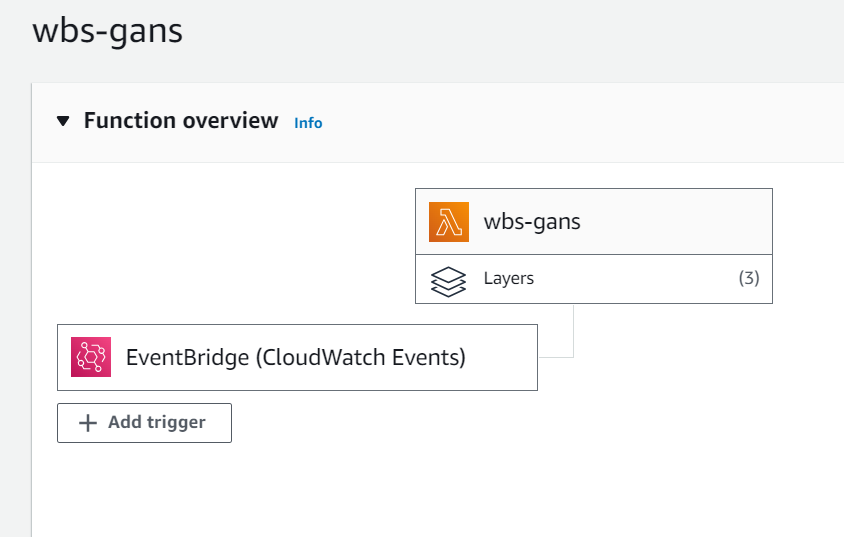

Our end goal is to schedule gans project functions to collect data about tomorrow’s weather and flight arrivals on a daily basis, therefore we'll set up a time triger every 12h.

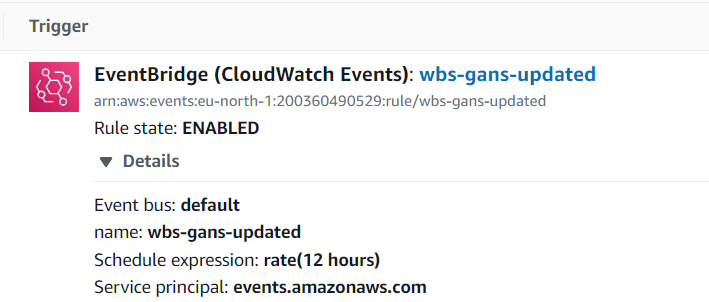

## 6. Conclusion

Gans project finished with success, now company has a new source of data that can help make more informed decision about placment of their scooters.

If you want to read more about my project you can read my article 'Digging Deep: From Archaeologist to Data Scientist. Conquering my First Data Engineering Project' you can find link in READme file.